# Chapter 13 - Data Science
## Data Manipulation

## 0 - Setting up the notebook

In [1]:
import json

import arrow
import pandas as pd
from pandas import DataFrame

## 1- Loading Data into a DataFrame

In [2]:
# Load data from a json file into a DataFrame
df = pd.read_json("data.json")

# let's take a peek at the first 5 rows, to make sure
# nothing weird has happened
df.head()

,cmp_name,cmp_bgt,cmp_spent,cmp_clicks,cmp_impr,user
0,KTR_20250404_20250916_35-50_A_EUR,964496,29586,36632,500001,"{""username"": ""epennington"", ""name"": ""Stephanie..."
1,AKX_20240130_20241017_20-25_M_GBP,344739,166010,67325,499999,"{""username"": ""epennington"", ""name"": ""Stephanie..."
2,BYU_20230828_20250115_25-45_M_GBP,177403,125738,29989,499997,"{""username"": ""joshua61"", ""name"": ""Diana Richar..."
3,AKX_20250216_20261129_45-60_F_USD,618256,75017,76301,500000,"{""username"": ""joshua61"", ""name"": ""Diana Richar..."
4,AKX_20231229_20250721_20-40_F_GBP,113805,12583,48915,500001,"{""username"": ""joshua61"", ""name"": ""Diana Richar..."


In [3]:
# let us see how many values there are  in each column
df.count()

cmp_name      5065
cmp_bgt       5065
cmp_spent     5065
cmp_clicks    5065
cmp_impr      5065
user          5065
dtype: int64

In [4]:
df.describe()

,cmp_bgt,cmp_spent,cmp_clicks,cmp_impr
count,5065.000000,5065.000000,5065.000000,5065.000000
mean,502965.054097,253389.854689,40265.781639,499999.474630
std,290468.998656,222774.897138,21840.783154,2.023801
min,1764.000000,107.000000,899.000000,499992.000000
25%,251171.000000,67071.000000,22575.000000,499998.000000
50%,500694.000000,187743.000000,36746.000000,499999.000000
75%,756850.000000,391790.000000,55817.000000,500001.000000
max,999565.000000,984705.000000,98379.000000,500007.000000


In [5]:
# let us see which are the top 3 campaigns according
# to budget (regardless of the currency)
df.sort_values(by=["cmp_bgt"], ascending=False).head(3)

,cmp_name,cmp_bgt,cmp_spent,cmp_clicks,cmp_impr,user
3186,GRZ_20230914_20230929_40-60_A_EUR,999565,358923,63869,499998,"{""username"": ""zsmith"", ""name"": ""Kimberly Stoke..."
3168,KTR_20250315_20260507_25-40_M_USD,999487,707699,21097,500000,"{""username"": ""brenda48"", ""name"": ""Brian Holden..."
3624,GRZ_20250227_20250617_30-45_F_USD,999482,153038,3435,499998,"{""username"": ""seanlee"", ""name"": ""Kenneth Gonza..."


In [6]:
# we can also use 'tail' to get the bottom 3 campaigns
df.sort_values(by=["cmp_bgt"], ascending=False).tail(3)

,cmp_name,cmp_bgt,cmp_spent,cmp_clicks,cmp_impr,user
725,GRZ_20240202_20250520_45-60_F_USD,1991,1070,65879,499999,"{""username"": ""burnsmark"", ""name"": ""Kayla Vega""..."
1032,GRZ_20231018_20241220_35-55_A_GBP,1839,1589,54180,499998,"{""username"": ""kimberly05"", ""name"": ""Robin Brow..."
4327,KTR_20240411_20260318_45-60_F_EUR,1764,1192,19340,499994,"{""username"": ""catherineherrera"", ""name"": ""Bren..."


## 2 - Manipulating the DataFrame

### Unpack campaign names
First, we will explode `cmp_name` into its components and get a separate DataFrame for those.

In [7]:
def unpack_campaign_name(name):
    # very optimistic method, assumes data in campaign name
    # is always in good state
    type_, start, end, age, gender, currency = name.split("_")
    start = arrow.get(start, "YYYYMMDD").date()
    end = arrow.get(end, "YYYYMMDD").date()
    return type_, start, end, age, gender, currency

In [8]:
# Apply unpack_campaign_name() to every row in the cmp_name column.
campaign_data = df["cmp_name"].apply(unpack_campaign_name)

In [9]:
campaign_cols = [
    "Type",
    "Start",
    "End",
    "Target Age",
    "Target Gender",
    "Currency",
]
campaign_df = DataFrame.from_records(
    campaign_data, columns=campaign_cols, index=df.index
)
campaign_df.head(3)

,Type,Start,End,Target Age,Target Gender,Currency
0,KTR,2025-04-04,2025-09-16,35-50,A,EUR
1,AKX,2024-01-30,2024-10-17,20-25,M,GBP
2,BYU,2023-08-28,2025-01-15,25-45,M,GBP


In [10]:
# let us join the two dataframes
df = df.join(campaign_df)

In [11]:
# inspect the data to make sure everything matches
df[["cmp_name"] + campaign_cols].head(3)

,cmp_name,Type,Start,End,Target Age,Target Gender,Currency
0,KTR_20250404_20250916_35-50_A_EUR,KTR,2025-04-04,2025-09-16,35-50,A,EUR
1,AKX_20240130_20241017_20-25_M_GBP,AKX,2024-01-30,2024-10-17,20-25,M,GBP
2,BYU_20230828_20250115_25-45_M_GBP,BYU,2023-08-28,2025-01-15,25-45,M,GBP


### Unpack user data

In [12]:
def unpack_user_json(user):
    # very optimistic as well, expects user objects
    # to have all attributes
    user = json.loads(user.strip())
    return [
        user["username"],
        user["email"],
        user["name"],
        user["gender"],
        user["age"],
        user["address"],
    ]


user_data = df["user"].apply(unpack_user_json)
user_cols = [
    "Username",
    "Email",
    "Name",
    "Gender",
    "Age",
    "Address",
]
user_df = DataFrame(
    user_data.tolist(), columns=user_cols, index=df.index
)

In [13]:
# let's join the two dataframes
df = df.join(user_df)

# inspect again to make sure everything matches
df[["user"] + user_cols].head(2)

,user,Username,Email,Name,Gender,Age,Address
0,"{""username"": ""epennington"", ""name"": ""Stephanie...",epennington,harmontammy@example.com,Stephanie Gonzalez,F,44,"48185 Brittany Green Suite 999\nEast Tanya, KS..."
1,"{""username"": ""epennington"", ""name"": ""Stephanie...",epennington,harmontammy@example.com,Stephanie Gonzalez,F,44,"48185 Brittany Green Suite 999\nEast Tanya, KS..."


### Rename columns

In [14]:
# now we have the DataFrame completely expanded, let us fix those ugly column names
new_column_names = {
    "cmp_bgt": "Budget",
    "cmp_spent": "Spent",
    "cmp_clicks": "Clicks",
    "cmp_impr": "Impressions",
}
df.rename(columns=new_column_names, inplace=True)

## 3 - Compute Some metrics

In [15]:
def calculate_metrics(df):
    # Click Through Rate
    df["CTR"] = df["Clicks"] / df["Impressions"]
    # Cost Per Click
    df["CPC"] = df["Spent"] / df["Clicks"]
    # Cost Per Impression
    df["CPI"] = df["Spent"] / df["Impressions"]


calculate_metrics(df)

In [16]:
df[["Spent", "Clicks", "Impressions", "CTR", "CPC", "CPI"]].head(
    3
)

,Spent,Clicks,Impressions,CTR,CPC,CPI
0,29586,36632,500001,0.073264,0.807655,0.059172
1,166010,67325,499999,0.134650,2.465800,0.332021
2,125738,29989,499997,0.059978,4.192804,0.251478


In [17]:
# let us take the values of the first row and verify
clicks = df["Clicks"][0]
impressions = df["Impressions"][0]
spent = df["Spent"][0]

CTR = df["CTR"][0]
CPC = df["CPC"][0]
CPI = df["CPI"][0]

print("CTR:", CTR, clicks / impressions)
print("CPC:", CPC, spent / clicks)
print("CPI:", CPI, spent / impressions)

CTR: 0.07326385347229306 0.07326385347229306
CPC: 0.8076545097182791 0.8076545097182791
CPI: 0.059171881656236686 0.059171881656236686


We also want the day of the week when each campaign started, and its duration

In [18]:
def get_day_of_the_week(day):
    return day.strftime("%A")


def get_duration(row):
    return (row["End"] - row["Start"]).days


df["Day of Week"] = df["Start"].apply(get_day_of_the_week)
df["Duration"] = df.apply(get_duration, axis="columns")

In [19]:
# let us verify
df[["Start", "End", "Duration", "Day of Week"]].head(3)

,Start,End,Duration,Day of Week
0,2025-04-04,2025-09-16,165,Friday
1,2024-01-30,2024-10-17,261,Tuesday
2,2023-08-28,2025-01-15,506,Monday


## 4 - Final Cleanup

In [20]:
# we can also get rid of the cmp_name, and user and address columns,
final_columns = [
    "Type",
    "Start",
    "End",
    "Duration",
    "Day of Week",
    "Budget",
    "Currency",
    "Clicks",
    "Impressions",
    "Spent",
    "CTR",
    "CPC",
    "CPI",
    "Target Age",
    "Target Gender",
    "Username",
    "Email",
    "Name",
    "Gender",
    "Age",
]
df = df[final_columns]

## 5 - Saving to a file in different formats

In [21]:
# CSV format
df.to_csv("df.csv")

In [22]:
# JSON format
df.to_json("df.json")

In [23]:
# Spreadsheet format
df.to_excel("df.xlsx")

## 6 - Visualizing results

First let's take care of the graphics, we configure the `matplotlib` plot style and set the font family to `serif`.

In [24]:
%matplotlib widget

In [25]:
import matplotlib.pyplot as plt

# Make the graphs nicer
plt.style.use(["classic", "ggplot"])

# Use a serif font
plt.rc("font", family="serif")

# Save high resolution figures suitable for printing
plt.rc("savefig", dpi=300)

In [26]:
df.describe()

,Duration,Budget,Clicks,Impressions,Spent,CTR,CPC,CPI,Age
count,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000,5065.000000
mean,369.488253,502965.054097,40265.781639,499999.474630,253389.854689,0.080532,10.131895,0.506780,53.882330
std,209.852969,290468.998656,21840.783154,2.023801,222774.897138,0.043682,19.527218,0.445550,21.170077
min,1.000000,1764.000000,899.000000,499992.000000,107.000000,0.001798,0.001493,0.000214,18.000000
25%,192.000000,251171.000000,22575.000000,499998.000000,67071.000000,0.045150,1.756140,0.134143,35.000000
50%,371.000000,500694.000000,36746.000000,499999.000000,187743.000000,0.073493,5.207316,0.375486,54.000000
75%,554.000000,756850.000000,55817.000000,500001.000000,391790.000000,0.111634,11.630131,0.783572,72.000000
max,730.000000,999565.000000,98379.000000,500007.000000,984705.000000,0.196758,462.814233,1.969410,90.000000


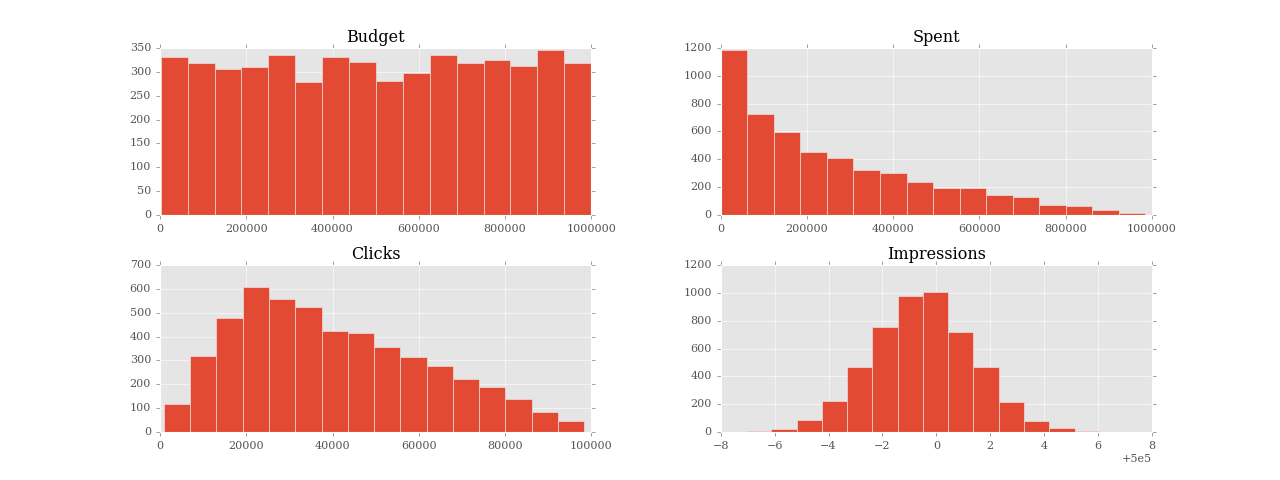

In [27]:
df[["Budget", "Spent", "Clicks", "Impressions"]].hist(
    bins=16, figsize=(16, 6)
)
plt.savefig("Figure13.4.png")

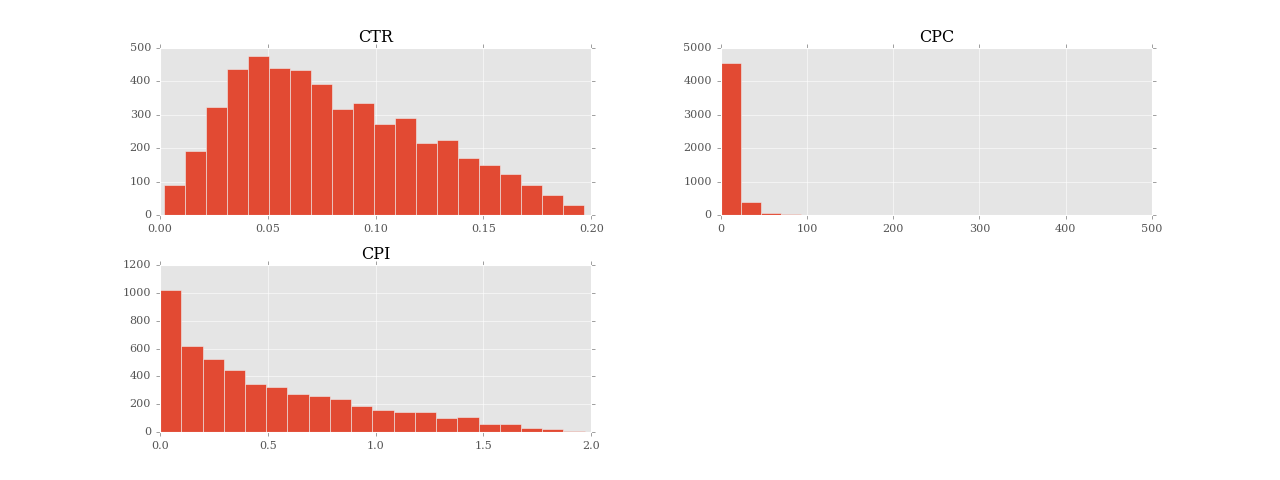

In [28]:
df[["CTR", "CPC", "CPI"]].hist(bins=20, figsize=(16, 6))
plt.savefig("Figure13.5.png")

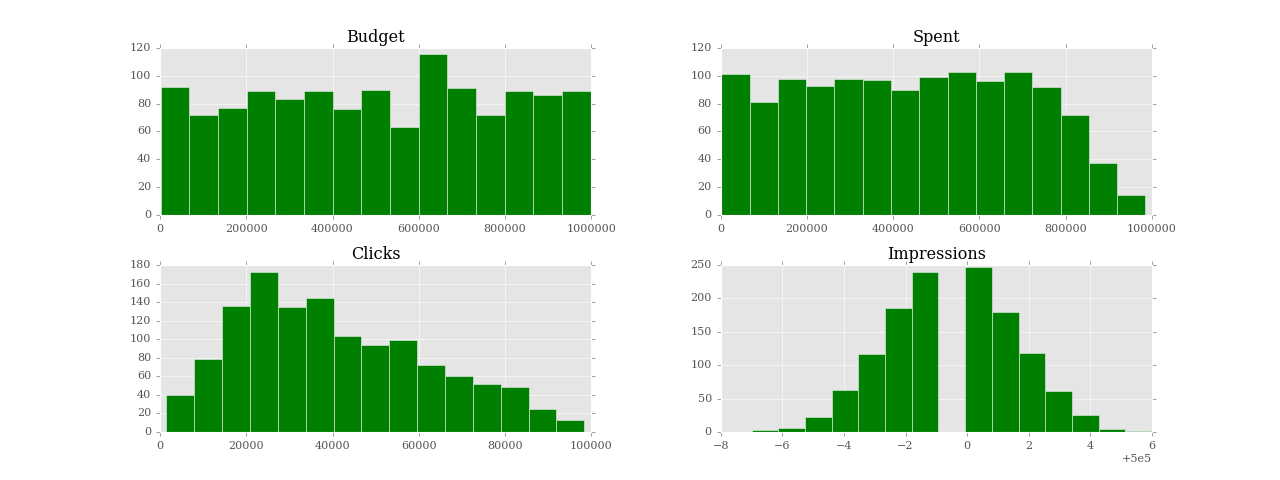

In [29]:
# let's see the campaigns whose spent is > than 75% of the budget
selector = df.Spent > df.Budget * 0.75
df[selector][["Budget", "Spent", "Clicks", "Impressions"]].hist(
    bins=15, figsize=(16, 6), color="green"
)
plt.savefig("Figure13.6.png")

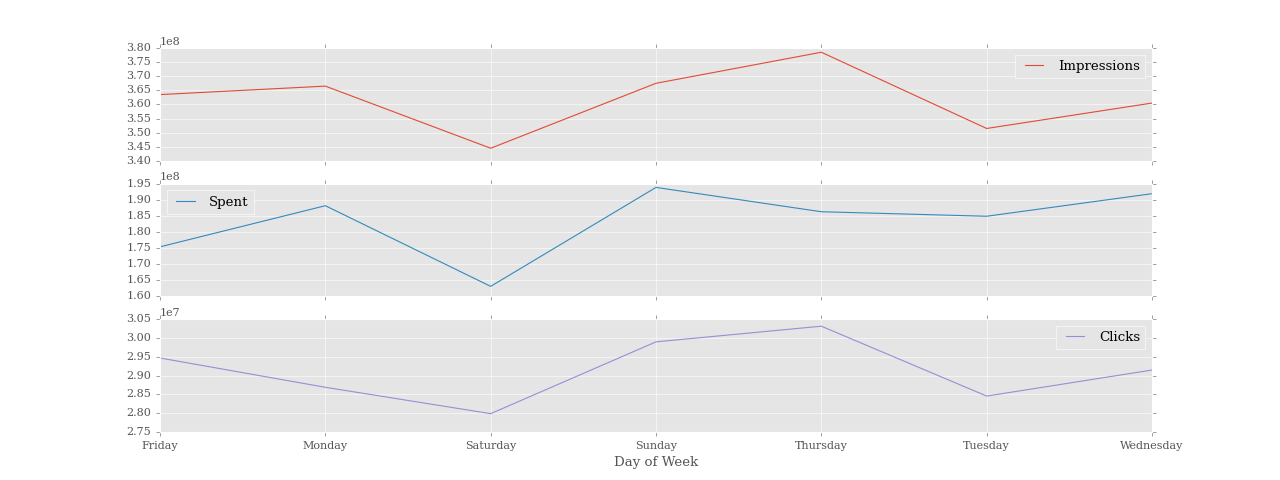

In [30]:
# Let's aggregate by Day of the Week
df_weekday = df.groupby(["Day of Week"]).sum(numeric_only=True)
df_weekday[["Impressions", "Spent", "Clicks"]].plot(
    figsize=(16, 6), subplots=True
)
plt.savefig("Figure13.7.png")

In [31]:
# Let's aggregate by gender and age
agg_config = {
    "Impressions": ["mean", "std"],
    "Spent": ["mean", "std"],
}

df.groupby(["Target Gender", "Target Age"]).agg(agg_config)

Impressions                    Spent  \
                                   mean       std           mean   
Target Gender Target Age                                           
A             20-25       499999.245614  2.189918  217330.771930   
              20-30       499999.465517  2.210148  252261.637931   
              20-35       499998.564103  1.774006  218726.410256   
              20-40       499999.459016  1.971241  255598.213115   
              20-45       499999.574074  2.245346  216527.666667   
...                                 ...       ...            ...   
M             45-50       499999.480769  2.128153  276112.557692   
              45-55       499999.306122  2.053494  267137.938776   
              45-60       499999.500000  1.984063  236623.312500   
              45-65       499999.679245  1.503503  215634.528302   
              45-70       499998.870370  1.822773  310267.944444   

                                         
                                    std  
Target Gender Target Age                 
A             20-25       204518.652595  
              20-30       228932.088945  
              20-35       215060.976707  
              20-40       222697.755231  
              20-45       190345.252888  
...                                 ...  
M             45-50       226975.008137  
              45-55       239249.474145  
              45-60       223464.578371  
              45-65       223308.046968  
              45-70       242353.980346  

[90 rows x 4 columns]

In [32]:
# finally, let's make a pivot table
df.pivot_table(
    values=["Impressions", "Clicks", "Spent"],
    index=["Target Age"],
    columns=["Target Gender"],
    aggfunc="sum",
)

Clicks                   Impressions                      \
Target Gender        A        F        M           A         F         M   
Target Age                                                                 
20-25          2460345  2355790  2954169    28499957  29999964  34999963   
20-30          2254458  1742729  2133740    28999969  21999963  25999959   
20-35          1323341  1735301  2926626    19499944  22499974  34999942   
20-40          2304325  1987013  1975200    30499967  28499973  26999950   
20-45          2402785  1667405  1790037    26999977  22499993  21999968   
25-30          2554594  2112054  1654070    28999991  24499954  21999959   
25-35          2262695  2688949  1552947    27499945  32499993  17999977   
25-40          2312824  2765216  1849825    25999955  30999968  27499964   
25-45          2636550  2302052  2359336    28499946  28999987  28999965   
25-50          2218490  2068886  2127728    29499980  25499953  26999972   
30-35          2468621  1910432  3099221    34999963  25499993  33499969   
30-40          2298939  2589451  2292862    28999966  31499972  26999968   
30-45          2616444  2048272  2254996    31499930  24000017  26999971   
30-50          2676730  2992745  1691940    35499952  34999971  22000001   
30-55          2285163  2042317  1896148    27499990  25999977  23999993   
35-40          2221694  2052499  2371541    27499963  24499985  28999970   
35-45          1669214  2444734  2336965    23499973  31499915  26499968   
35-50          2079197  2210849  2636434    28999969  32499959  29499985   
35-55          2032124  2696916  2050578    24999971  31999968  27999975   
35-60          2568010  2490988  2288088    26499980  31499959  28499984   
40-45          2273514  2551116  2530067    28499979  31999953  29999956   
40-50          2657318  2174374  2724277    31999966  25499999  30999968   
40-55          2496766  2017712  1996308    32499956  23500003  28500012   
40-60          2258586  1994181  1977123    30499976  24499978  27499981   
40-65          2353368  2474574  2531935    28999981  27999981  31999969   
45-50          2363777  2752142  1898628    29999959  33499945  25999973   
45-55          2898843  2411690  1929080    30499970  30500003  24499966   
45-60          2323099  2628039  2698876    29499980  31999972  31999968   
45-65          2451874  1892687  1983735    30499968  25499983  26499983   
45-70          2060369  1841268  2007266    26499968  22499975  26999939   

                  Spent                      
Target Gender         A         F         M  
Target Age                                   
20-25          12387854  16271204  14605751  
20-30          14631175  11435369  13184984  
20-35           8530330  10987452  18383305  
20-40          15591491  15490069  13806347  
20-45          11692494   9064229   9623006  
25-30          21384048  10951922  11336787  
25-35          15835588  17568960  10440487  
25-40          12218317  12534598  15152483  
25-45          14611597  13040278  14584821  
25-50          14070093  10688162  15336580  
30-35          23357728  11656842  18382424  
30-40          15448034  13799337  13037479  
30-45          14213835   9756196  12721961  
30-50          22490468  19251726  10650649  
30-55          14167102  13839757  10990401  
35-40          14353641   9535254  13945054  
35-45          11028491  16333287  12104330  
35-50          17444423  15951931  18302824  
35-55          15266919  21385299  13371221  
35-60          14889775  15658231  13413552  
40-45          12504560  16291722  14740888  
40-50          15890075  13345592  15082723  
40-55          16731630  13797387  12767689  
40-60          16366979  12751785  12815735  
40-65          14228005  14065243  17911485  
45-50          13052723  17520280  14357853  
45-55          13487602  15002737  13089759  
45-60          16797214  13671906  15143892  
45-65          15119530  11422840  11428630  
45-70          13907778  11182951  